In [1]:
# import libs
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# cek device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
!pip install torchsummary

In [3]:
def compute_mean_std(dataset):
    """Compute per-channel mean and std of a dataset."""
    loader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=2)
    mean = 0.0
    std = 0.0
    total_images = 0
    
    for images, _ in loader:
        # flatten: [batch, channels, height, width] -> [batch, channels, -1]
        images = images.view(images.size(0), images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += images.size(0)
    
    mean /= total_images
    std /= total_images
    return mean, std

In [4]:
raw_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)

100%|██████████| 170M/170M [08:41<00:00, 327kB/s] 


In [5]:
train_mean, train_std = compute_mean_std(raw_train_dataset)
print("Train set mean:", train_mean)
print("Train set std:", train_std)

Train set mean: tensor([0.4914, 0.4822, 0.4465])
Train set std: tensor([0.2023, 0.1994, 0.2010])


In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(train_mean.tolist(), train_std.tolist()),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean.tolist(), train_std.tolist()),
])


In [7]:
# load dataset with transforms
train_dataset_full = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=train_transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=test_transform
)

In [8]:
# Split training into train/val (45k/5k)
train_size = int(0.9 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

print(f"Train set: {len(train_dataset)} images")
print(f"Val set:   {len(val_dataset)} images")
print(f"Test set:  {len(test_dataset)} images")

Train set: 45000 images
Val set:   5000 images
Test set:  10000 images


In [9]:
# dataloader
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_dataset_full.classes
print("Classes:", classes)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Baseline Model

In [10]:
# Baseline CNN (Paper)
class PaperCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(PaperCNN, self).__init__()
        
        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                               kernel_size=3, stride=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=3, stride=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 1 * 1, 128)   # Adjust input size carefully
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # logits (softmax diapply di loss functions)
        return x

# init model
baseline_model = PaperCNN(num_classes=len(classes)).to(device)

# Print model summary (params)
from torchsummary import summary
summary(baseline_model, (3, 32, 32))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 11, 11]             896
         MaxPool2d-2             [-1, 32, 5, 5]               0
            Conv2d-3             [-1, 64, 2, 2]          18,496
         MaxPool2d-4             [-1, 64, 1, 1]               0
           Flatten-5                   [-1, 64]               0
            Linear-6                  [-1, 128]           8,320
            Linear-7                   [-1, 64]           8,256
            Linear-8                   [-1, 10]             650
Total params: 36,618
Trainable params: 36,618
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.14
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


In [11]:
# train setup
criterion = nn.CrossEntropyLoss()

# Paper mentions SGD + momentum (no scheduler)
optimizer = optim.SGD(baseline_model.parameters(), 
                      lr=0.01, momentum=0.9)

# main loop for trainning
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# model train
num_epochs = 20  # as stated in the paper
train_history, val_history = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(baseline_model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(baseline_model, val_loader, criterion, device)

    train_history.append((train_loss, train_acc))
    val_history.append((val_loss, val_acc))

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# eval
test_loss, test_acc = evaluate(baseline_model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch [1/20] Train Loss: 2.0446, Train Acc: 0.2463 | Val Loss: 1.7732, Val Acc: 0.3520
Epoch [2/20] Train Loss: 1.6215, Train Acc: 0.4050 | Val Loss: 1.5971, Val Acc: 0.4176
Epoch [3/20] Train Loss: 1.4747, Train Acc: 0.4642 | Val Loss: 1.4469, Val Acc: 0.4784
Epoch [4/20] Train Loss: 1.3990, Train Acc: 0.4935 | Val Loss: 1.4223, Val Acc: 0.4692
Epoch [5/20] Train Loss: 1.3476, Train Acc: 0.5148 | Val Loss: 1.3330, Val Acc: 0.5214
Epoch [6/20] Train Loss: 1.2988, Train Acc: 0.5317 | Val Loss: 1.2847, Val Acc: 0.5324
Epoch [7/20] Train Loss: 1.2553, Train Acc: 0.5480 | Val Loss: 1.2786, Val Acc: 0.5412
Epoch [8/20] Train Loss: 1.2347, Train Acc: 0.5571 | Val Loss: 1.2373, Val Acc: 0.5556
Epoch [9/20] Train Loss: 1.2029, Train Acc: 0.5679 | Val Loss: 1.2095, Val Acc: 0.5676
Epoch [10/20] Train Loss: 1.1817, Train Acc: 0.5750 | Val Loss: 1.1965, Val Acc: 0.5758
Epoch [11/20] Train Loss: 1.1624, Train Acc: 0.5832 | Val Loss: 1.1917, Val Acc: 0.5752
Epoch [12/20] Train Loss: 1.1442, Train A

              precision    recall  f1-score   support

    airplane     0.6734    0.6310    0.6515      1000
  automobile     0.7233    0.7240    0.7236      1000
        bird     0.5461    0.4740    0.5075      1000
         cat     0.4734    0.3740    0.4179      1000
        deer     0.5477    0.5800    0.5634      1000
         dog     0.4941    0.6230    0.5511      1000
        frog     0.7124    0.7160    0.7142      1000
       horse     0.6809    0.6850    0.6830      1000
        ship     0.6870    0.8120    0.7443      1000
       truck     0.7329    0.6530    0.6906      1000

    accuracy                         0.6272     10000
   macro avg     0.6271    0.6272    0.6247     10000
weighted avg     0.6271    0.6272    0.6247     10000



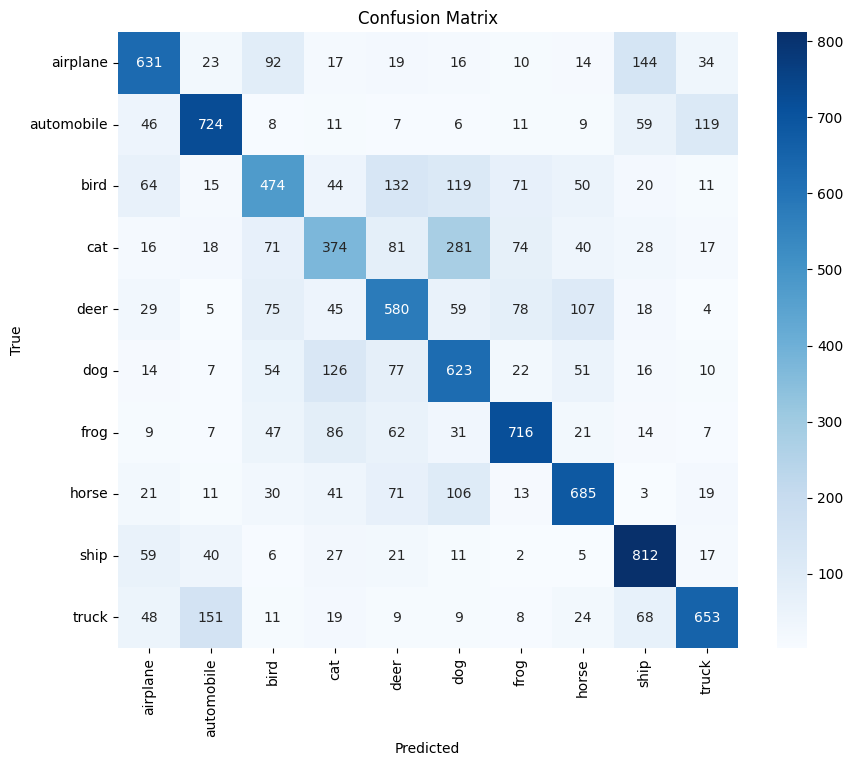

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_detailed(model, loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Run after test evaluation
evaluate_detailed(baseline_model, test_loader, device, classes)


## CNN+CBAM

In [13]:
# Cbam
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        # Shared MLP
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(concat)
        return self.sigmoid(out)


class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, spatial_kernel=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(spatial_kernel)

    def forward(self, x):
        # Channel Attention
        ca = self.channel_attention(x)
        x = x * ca

        # Spatial Attention
        sa = self.spatial_attention(x)
        x = x * sa
        return x


In [14]:
# CBAM-CNN (same depth as baseline)
class CBAM_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CBAM_CNN, self).__init__()

        # Conv block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=3, padding=1)
        self.cbam1 = CBAM(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=3, padding=1)
        self.cbam2 = CBAM(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers (same as baseline)
        self.fc1 = nn.Linear(64 * 1 * 1, 128)  
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Block 1
        x = F.relu(self.conv1(x))
        x = self.cbam1(x)
        x = self.pool1(x)

        # Block 2
        x = F.relu(self.conv2(x))
        x = self.cbam2(x)
        x = self.pool2(x)

        # Flatten + FC
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [15]:
cbam_model = CBAM_CNN(num_classes=len(classes)).to(device)

from torchsummary import summary
summary(cbam_model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 11, 11]             896
 AdaptiveAvgPool2d-2             [-1, 32, 1, 1]               0
            Conv2d-3              [-1, 2, 1, 1]              64
              ReLU-4              [-1, 2, 1, 1]               0
            Conv2d-5             [-1, 32, 1, 1]              64
 AdaptiveMaxPool2d-6             [-1, 32, 1, 1]               0
            Conv2d-7              [-1, 2, 1, 1]              64
              ReLU-8              [-1, 2, 1, 1]               0
            Conv2d-9             [-1, 32, 1, 1]              64
          Sigmoid-10             [-1, 32, 1, 1]               0
 ChannelAttention-11             [-1, 32, 1, 1]               0
           Conv2d-12            [-1, 1, 11, 11]              98
          Sigmoid-13            [-1, 1, 11, 11]               0
 SpatialAttention-14            [-1, 1,

## Residual CNN

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # Main conv path
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

        # Projection shortcut if channels/stride mismatch
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.bn(self.conv(x))
        shortcut = self.shortcut(x)
        out = out + shortcut
        return F.relu(out)


In [17]:
class ResidualCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ResidualCNN, self).__init__()

        # Block 1
        self.resblock1 = ResidualBlock(3, 32, stride=3)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2
        self.resblock2 = ResidualBlock(32, 64, stride=3)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 1 * 1, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Block 1
        x = self.resblock1(x)
        x = self.pool1(x)

        # Block 2
        x = self.resblock2(x)
        x = self.pool2(x)

        # Flatten + FC
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [18]:
residual_model = ResidualCNN(num_classes=len(classes)).to(device)

from torchsummary import summary
summary(residual_model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 11, 11]             864
       BatchNorm2d-2           [-1, 32, 11, 11]              64
            Conv2d-3           [-1, 32, 11, 11]              96
       BatchNorm2d-4           [-1, 32, 11, 11]              64
     ResidualBlock-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 2, 2]          18,432
       BatchNorm2d-8             [-1, 64, 2, 2]             128
            Conv2d-9             [-1, 64, 2, 2]           2,048
      BatchNorm2d-10             [-1, 64, 2, 2]             128
    ResidualBlock-11             [-1, 64, 2, 2]               0
        MaxPool2d-12             [-1, 64, 1, 1]               0
           Linear-13                  [-1, 128]           8,320
           Linear-14                   

In [19]:
class ThreeConvCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ThreeConvCNN, self).__init__()

        # Conv block 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Conv block 3 (no pooling here)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))  # no pool3, stays 1x1

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [20]:
threeconv_model = ThreeConvCNN(num_classes=len(classes)).to(device)

from torchsummary import summary
summary(threeconv_model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 11, 11]             896
         MaxPool2d-2             [-1, 32, 5, 5]               0
            Conv2d-3             [-1, 64, 2, 2]          18,496
         MaxPool2d-4             [-1, 64, 1, 1]               0
            Conv2d-5            [-1, 128, 1, 1]          73,856
            Linear-6                  [-1, 256]          33,024
            Linear-7                  [-1, 128]          32,896
            Linear-8                   [-1, 10]           1,290
Total params: 160,458
Trainable params: 160,458
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 0.61
Estimated Total Size (MB): 0.67
----------------------------------------------------------------


## Training Time


 Training PaperCNN 
Epoch [1/20] Train Acc: 0.2628 | Val Acc: 0.3724
Epoch [2/20] Train Acc: 0.4142 | Val Acc: 0.4540
Epoch [3/20] Train Acc: 0.4699 | Val Acc: 0.4944
Epoch [4/20] Train Acc: 0.5019 | Val Acc: 0.5146
Epoch [5/20] Train Acc: 0.5227 | Val Acc: 0.5252
Epoch [6/20] Train Acc: 0.5383 | Val Acc: 0.5356
Epoch [7/20] Train Acc: 0.5531 | Val Acc: 0.5640
Epoch [8/20] Train Acc: 0.5656 | Val Acc: 0.5636
Epoch [9/20] Train Acc: 0.5710 | Val Acc: 0.5810
Epoch [10/20] Train Acc: 0.5823 | Val Acc: 0.5780
Epoch [11/20] Train Acc: 0.5886 | Val Acc: 0.5822
Epoch [12/20] Train Acc: 0.5994 | Val Acc: 0.5758
Epoch [13/20] Train Acc: 0.5998 | Val Acc: 0.5874
Epoch [14/20] Train Acc: 0.6039 | Val Acc: 0.5962
Epoch [15/20] Train Acc: 0.6087 | Val Acc: 0.5938
Epoch [16/20] Train Acc: 0.6112 | Val Acc: 0.5870
Epoch [17/20] Train Acc: 0.6172 | Val Acc: 0.5988
Epoch [18/20] Train Acc: 0.6194 | Val Acc: 0.6000
Epoch [19/20] Train Acc: 0.6245 | Val Acc: 0.6088
Epoch [20/20] Train Acc: 0.6238 | Val 

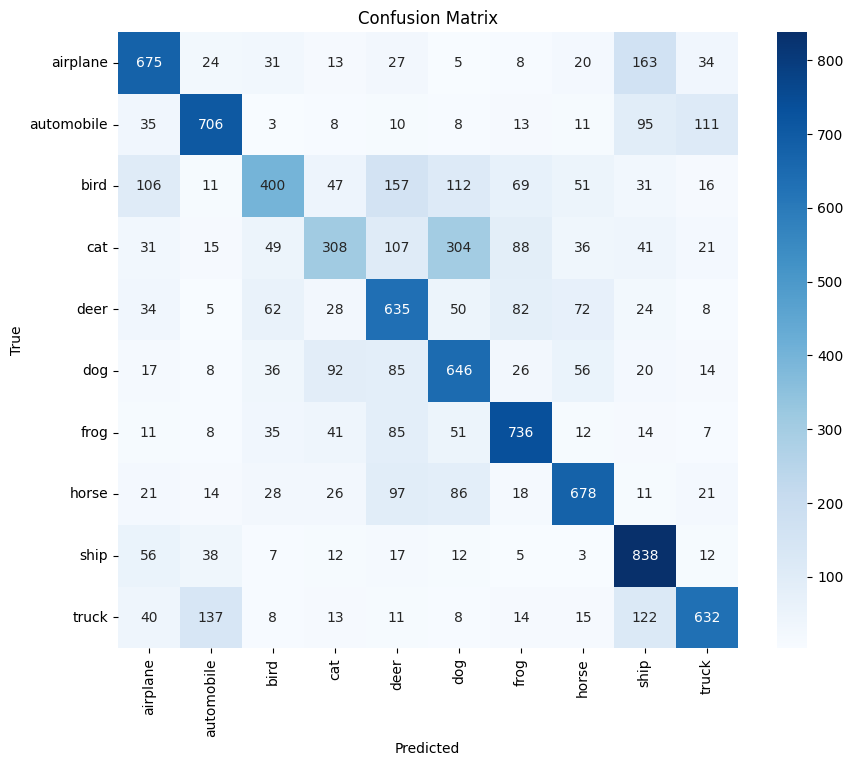


 Training CBAM-CNN 
Epoch [1/20] Train Acc: 0.0999 | Val Acc: 0.0946
Epoch [2/20] Train Acc: 0.1121 | Val Acc: 0.1434
Epoch [3/20] Train Acc: 0.1376 | Val Acc: 0.1420
Epoch [4/20] Train Acc: 0.2007 | Val Acc: 0.2638
Epoch [5/20] Train Acc: 0.3416 | Val Acc: 0.3962
Epoch [6/20] Train Acc: 0.4200 | Val Acc: 0.4406
Epoch [7/20] Train Acc: 0.4590 | Val Acc: 0.4812
Epoch [8/20] Train Acc: 0.4849 | Val Acc: 0.4902
Epoch [9/20] Train Acc: 0.5054 | Val Acc: 0.5114
Epoch [10/20] Train Acc: 0.5213 | Val Acc: 0.5318
Epoch [11/20] Train Acc: 0.5303 | Val Acc: 0.5208
Epoch [12/20] Train Acc: 0.5406 | Val Acc: 0.5194
Epoch [13/20] Train Acc: 0.5470 | Val Acc: 0.5484
Epoch [14/20] Train Acc: 0.5590 | Val Acc: 0.5514
Epoch [15/20] Train Acc: 0.5650 | Val Acc: 0.5592
Epoch [16/20] Train Acc: 0.5713 | Val Acc: 0.5586
Epoch [17/20] Train Acc: 0.5750 | Val Acc: 0.5670
Epoch [18/20] Train Acc: 0.5801 | Val Acc: 0.5702
Epoch [19/20] Train Acc: 0.5844 | Val Acc: 0.5704
Epoch [20/20] Train Acc: 0.5937 | Val 

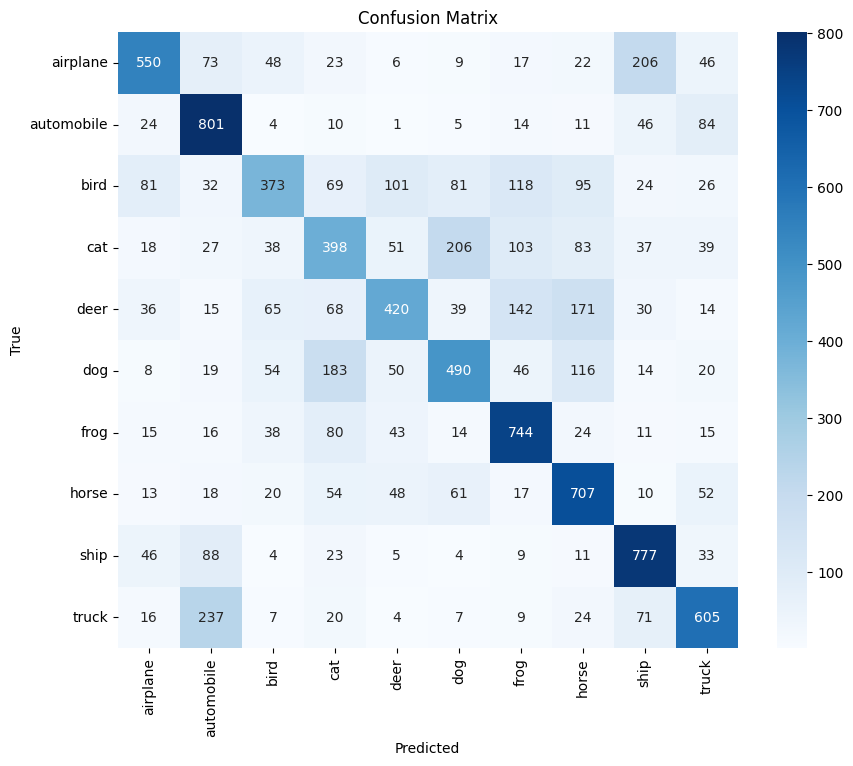


 Training Residual-CNN 
Epoch [1/20] Train Acc: 0.3316 | Val Acc: 0.4284
Epoch [2/20] Train Acc: 0.4665 | Val Acc: 0.4722
Epoch [3/20] Train Acc: 0.5097 | Val Acc: 0.5174
Epoch [4/20] Train Acc: 0.5369 | Val Acc: 0.5240
Epoch [5/20] Train Acc: 0.5545 | Val Acc: 0.5454
Epoch [6/20] Train Acc: 0.5674 | Val Acc: 0.5656
Epoch [7/20] Train Acc: 0.5784 | Val Acc: 0.5624
Epoch [8/20] Train Acc: 0.5850 | Val Acc: 0.5658
Epoch [9/20] Train Acc: 0.5917 | Val Acc: 0.5884
Epoch [10/20] Train Acc: 0.5976 | Val Acc: 0.5852
Epoch [11/20] Train Acc: 0.6040 | Val Acc: 0.5874
Epoch [12/20] Train Acc: 0.6094 | Val Acc: 0.5824
Epoch [13/20] Train Acc: 0.6138 | Val Acc: 0.5924
Epoch [14/20] Train Acc: 0.6174 | Val Acc: 0.6036
Epoch [15/20] Train Acc: 0.6227 | Val Acc: 0.6046
Epoch [16/20] Train Acc: 0.6260 | Val Acc: 0.6242
Epoch [17/20] Train Acc: 0.6291 | Val Acc: 0.6132
Epoch [18/20] Train Acc: 0.6286 | Val Acc: 0.6180
Epoch [19/20] Train Acc: 0.6334 | Val Acc: 0.6108
Epoch [20/20] Train Acc: 0.6366 | 

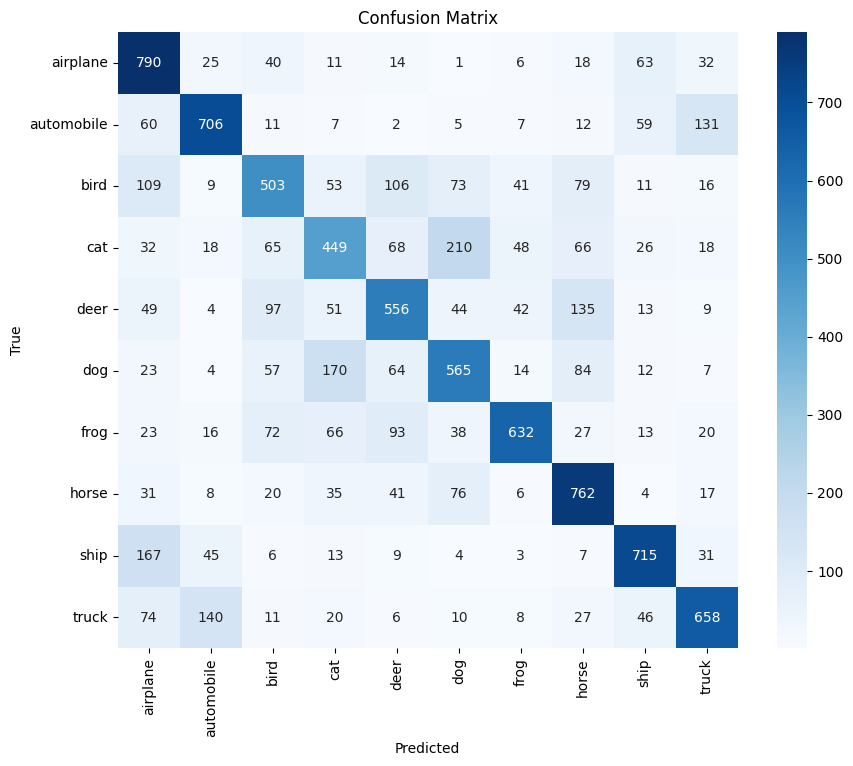


 Training ThreeConvCNN 
Epoch [1/20] Train Acc: 0.1419 | Val Acc: 0.1730
Epoch [2/20] Train Acc: 0.2447 | Val Acc: 0.3300
Epoch [3/20] Train Acc: 0.3569 | Val Acc: 0.3862
Epoch [4/20] Train Acc: 0.4142 | Val Acc: 0.4404
Epoch [5/20] Train Acc: 0.4594 | Val Acc: 0.4534
Epoch [6/20] Train Acc: 0.4832 | Val Acc: 0.4888
Epoch [7/20] Train Acc: 0.4987 | Val Acc: 0.5014
Epoch [8/20] Train Acc: 0.5183 | Val Acc: 0.5200
Epoch [9/20] Train Acc: 0.5286 | Val Acc: 0.5380
Epoch [10/20] Train Acc: 0.5449 | Val Acc: 0.5476
Epoch [11/20] Train Acc: 0.5518 | Val Acc: 0.5452
Epoch [12/20] Train Acc: 0.5639 | Val Acc: 0.5480
Epoch [13/20] Train Acc: 0.5712 | Val Acc: 0.5560
Epoch [14/20] Train Acc: 0.5794 | Val Acc: 0.5754
Epoch [15/20] Train Acc: 0.5849 | Val Acc: 0.5754
Epoch [16/20] Train Acc: 0.5897 | Val Acc: 0.5822
Epoch [17/20] Train Acc: 0.5988 | Val Acc: 0.5768
Epoch [18/20] Train Acc: 0.6020 | Val Acc: 0.5876
Epoch [19/20] Train Acc: 0.6075 | Val Acc: 0.5930
Epoch [20/20] Train Acc: 0.6090 | 

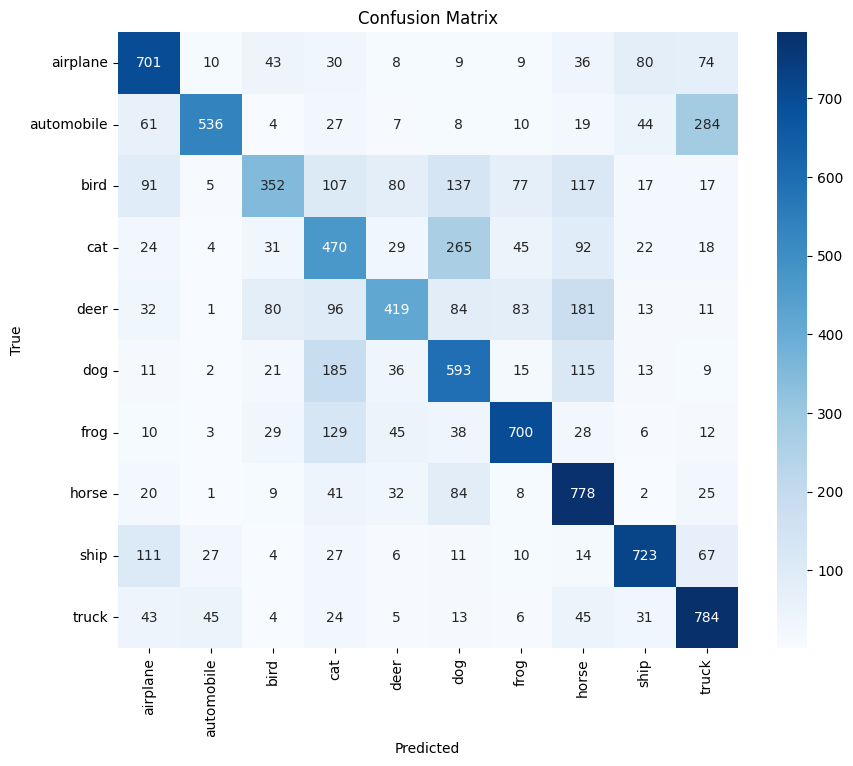


 Final Results 
          Model  Test Acc  Params  Inf Time (ms/img)
0      PaperCNN    0.6254   36618           0.007072
1      CBAM-CNN    0.5865   37454           0.019698
2  Residual-CNN    0.6336   39050           0.012213
3  ThreeConvCNN    0.6056  160458           0.008536


In [21]:
import time
import pandas as pd

# Helper: count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Helper: measure inference time (average per batch)
def measure_inference_time(model, loader, device, num_batches=20):
    model.eval()
    times = []
    with torch.no_grad():
        for i, (inputs, _) in enumerate(loader):
            if i >= num_batches: break
            inputs = inputs.to(device)
            torch.cuda.synchronize() if device.type == "cuda" else None
            start = time.time()
            _ = model(inputs)
            torch.cuda.synchronize() if device.type == "cuda" else None
            end = time.time()
            times.append(end - start)
    return np.mean(times) / inputs.size(0)  # per image

# Runner: train + evaluate a model
def run_experiment(model, name, train_loader, val_loader, test_loader, device, epochs=20):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    print(f"\n Training {name} ")
    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        print(f"Epoch [{epoch+1}/{epochs}] Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Final test evaluation
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    inf_time = measure_inference_time(model, test_loader, device)
    n_params = count_parameters(model)

    print(f"\n{name} Test Accuracy: {test_acc:.4f}, Params: {n_params}, Inference time/img: {inf_time*1000:.3f} ms")

    # Detailed metrics
    evaluate_detailed(model, test_loader, device, classes)

    return {
        "Model": name,
        "Test Acc": test_acc,
        "Params": n_params,
        "Inf Time (ms/img)": inf_time*1000
    }

# run all model
results = []

models = {
    "PaperCNN": PaperCNN(num_classes=len(classes)).to(device),
    "CBAM-CNN": CBAM_CNN(num_classes=len(classes)).to(device),
    "Residual-CNN": ResidualCNN(num_classes=len(classes)).to(device),
    "ThreeConvCNN": ThreeConvCNN(num_classes=len(classes)).to(device),
}

for name, model in models.items():
    results.append(run_experiment(model, name, train_loader, val_loader, test_loader, device, epochs=20))

# save result
df_results = pd.DataFrame(results)
print("\n Final Results ")
print(df_results)
